# Player Tracking Study

### Importing Common Libraries and Setting Up Globals

In [1]:
import sys

# Set this to the absolute path of your project root
project_root = "/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from typing import Optional, List, Dict, Tuple
import torch
import supervision as sv
from tqdm import tqdm
from collections import deque
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import umap

from modules.detection import DetectionModel
from modules.player import Player
from modules.team_identification import TeamIdentification
from tools.store_driver import Store
from modules.custom_tracker import AffineAwareByteTrack
from modules.Siglip_reid import SiglipReID

W0706 17:31:17.913000 75195 .venv312/lib/python3.12/site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Defining video input parameters

In [2]:
input_video = "/Users/fernandomousinho/Library/CloudStorage/GoogleDrive-fmousinho76@gmail.com/My Drive/Colab_Notebooks/FCA_Upstate_NY_003.mp4"
store = Store()
device = torch.device("cpu")
debug_max_frames = 200

Gathering required crops. We are saving crops_for_team_id_backup, which can be copied to crops_for_team_id in each experiment.

In [3]:
video_info = sv.VideoInfo.from_video_path(video_path=input_video)
generator_params = {
    "source_path": input_video,
    "end": debug_max_frames if debug_max_frames else video_info.total_frames,
}
frames_generator = sv.get_video_frames_generator(**generator_params)
model = DetectionModel(store=store, device=device)

tracker = AffineAwareByteTrack() 
team_identifier = TeamIdentification()
emb_provider = SiglipReID()

ellipse_annotator = sv.EllipseAnnotator()
label_annotator = sv.LabelAnnotator()
multi_frame_detections = deque()
multi_ineligible_track_ids_team_0: deque[list[int]] = deque()
multi_ineligible_track_ids_team_1: deque[list[int]] = deque()
trackerid_to_reid_data: Dict[int, Tuple[np.ndarray, int]] = {}

frame_target = debug_max_frames if debug_max_frames else video_info.total_frames

# Identifying teams
_N_FRAMES_FOR_TEAM_ID = 100
_PLAYER_CLASS_ID = 3

stride = frame_target // _N_FRAMES_FOR_TEAM_ID if frame_target >= _N_FRAMES_FOR_TEAM_ID else 1
crops_for_team_id: List[np.ndarray] = []
# Create a fresh generator for this step to avoid exhaustion
frame_generator_for_team_id = sv.get_video_frames_generator(stride=stride, **generator_params)

# Calculate how many frames will actually be processed for progress bar
n_frames_for_team_id = frame_target // stride if stride > 0 else frame_target
for frame in tqdm(frame_generator_for_team_id, desc="Gathering crops for team identification", total=n_frames_for_team_id):
    all_detections = model.generate_detections(frame)
    # all_detections = all_detections.with_nms(threshold=0.9, class_agnostic=True)
    player_detections = all_detections[all_detections.class_id == _PLAYER_CLASS_ID]
    for bbox in player_detections.xyxy:
        crop = sv.crop_image(frame, xyxy=bbox)
        if crop is not None:
            crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)  # Ensure crop is in RGB format
            crops_for_team_id.append(crop)

crops_for_team_id_backup = crops_for_team_id.copy()

Loading pretrain weights


Gathering crops for team identification: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


Saving a backup for the flattened version of each crop, in normalized RGB.

In [4]:
crops = crops_for_team_id_backup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
shapes = []
flat_crop_array = []
for crop_copy in roi_crops:
    crop = crop_copy.copy()
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop = flat_crop.astype(np.float32)
    flat_crop_norm = flat_crop / 255.0
    flat_crop_array.append(flat_crop_norm)
flat_crop_norm = np.concatenate(flat_crop_array, axis=0)
flat_crop_norm_backup = flat_crop_norm.copy()


Checking if it is really RGB!

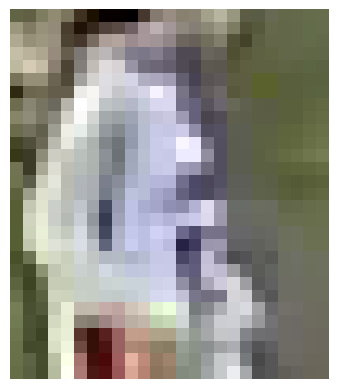

In [5]:
plt.imshow(roi_crops[0])
plt.axis('off')
plt.show()

##### Update SIGLip Module ####

Only required if it needs reload.

In [6]:
import importlib
import modules.Siglip_reid  # Import the module first
importlib.reload(modules.Siglip_reid)  # Reload the module
from modules.Siglip_reid import SiglipReID  # Re-import the class

### Experiment 1: Determining grass color via kmeans

#### RGB ####
Not good enough. The dark parts of the uniform are being masked-out, preventing an accurate team separation

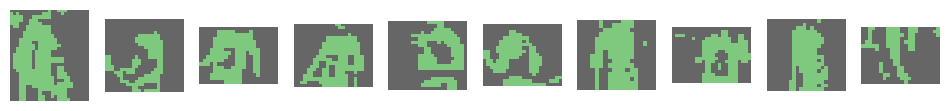

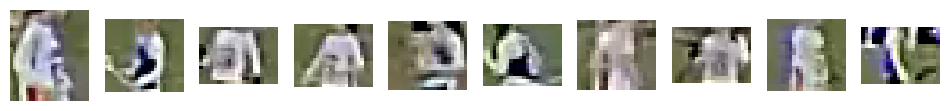

In [9]:
flat_crop_norm = flat_crop_norm_backup.copy()
kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_norm)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

roi_for_plot_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in roi_crops]
sv.plot_images_grid(roi_for_plot_bgr[:10], grid_size=(1, 10))

#### HSV ####

Same results as before.

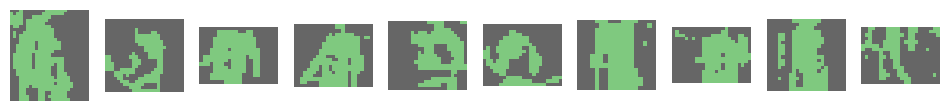

In [11]:
crops = crops_for_team_id_backup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
roi_crops_hue = [cv2.cvtColor(crop, cv2.COLOR_BGR2HSV) for crop in roi_crops]
shapes = []
flat_crop_array = []
for crop in roi_crops_hue:
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop_array.append(flat_crop)
flat_crop_np = np.concatenate(flat_crop_array, axis=0)


kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_np)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

#### LAB ####

Same as before.

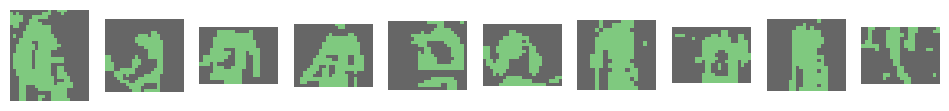

In [13]:
crops = crops_for_team_id_backup.copy()
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
roi_crops_lab = [cv2.cvtColor(crop, cv2.COLOR_BGR2LAB) for crop in roi_crops]
shapes = []
flat_crop_array = []
for crop in roi_crops_lab:
    shapes.append(crop.shape)
    flat_crop = crop.reshape(-1, 3)
    flat_crop_array.append(flat_crop)
flat_crop_np = np.concatenate(flat_crop_array, axis=0)


kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_np)
masked_crops = []
start = 0
stop = 0
for shape in shapes:
    stop = start + shape[0] * shape[1] 
    flat_crop = player_or_grass_mask[start:stop]
    masked_crop = np.reshape(flat_crop, shape[:2])
    masked_crops.append(masked_crop.copy())
    start = stop

sv.plot_images_grid(masked_crops[:10], grid_size=(1, 10), cmap='Accent')

Verifying that the resulting masked colors really don't work.

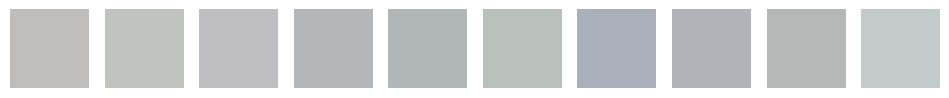

In [14]:
pic = masked_crops[0].copy()
edge_colors = [pic[0, 0], pic[0, -1], pic[-1, 0], pic[-1, -1]]
background_cluster = max(set(edge_colors), key=edge_colors.count)
player_img_cluster = 1 - background_cluster
crops_mean_color = []
for crop, masked_crop in zip(roi_crops, masked_crops):
    mean_color = np.mean(crop[masked_crop == player_img_cluster], axis=0).astype(np.uint8)
    mean_color = cv2.cvtColor(mean_color.reshape(1, 1, 3), cv2.COLOR_BGR2RGB)
    crops_mean_color.append(mean_color.reshape(3))

color_patches = [np.full((50, 50, 3), color, dtype=np.uint8) for color in crops_mean_color[:10]]
color_patches = [cv2.cvtColor(patch, cv2.COLOR_RGB2BGR) for patch in color_patches]
sv.plot_images_grid(color_patches, grid_size=(1, 10))

### Experiment 2: Morphological Operations ###

Check https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

#### Generate Morphological Masks ####

Original crops


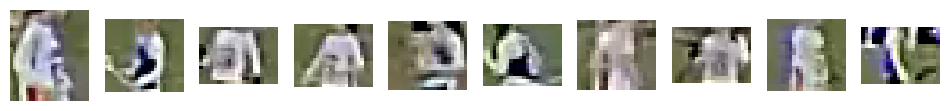

Masks


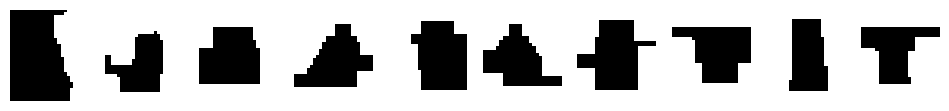

Masked crops


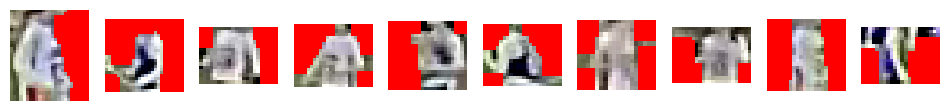

In [ ]:
flat_crop_norm = flat_crop_norm_backup.copy()
kmeans_background = KMeans(n_clusters=2, random_state = 42)
player_or_grass_mask = kmeans_background.fit_predict(flat_crop_norm)
masked_crops = []
masks_rgb = []
start = 0
stop = 0
kernel_open_size = 7
kernel_close_size = 1
kernel_open = np.ones((kernel_open_size, kernel_open_size), np.uint8)
kernel_close = np.ones((kernel_close_size, kernel_close_size), np.uint8)
for i, shape in enumerate(shapes):
    stop = start + shape[0] * shape[1] 
    flat_mask = player_or_grass_mask[start:stop]
    mask = np.reshape(flat_mask, shape[:2])
    mask_edges = set([mask[0, 0], mask[0, -1], mask[-1, 0], mask[-1, -1]])
    grass_cluster = max(mask_edges, key=list(mask_edges).count)
    player_img_cluster = 1 - grass_cluster
    mask = (mask == player_img_cluster).astype(np.uint8)
    mask_rgb = cv2.cvtColor(mask.astype(np.uint8) * 255, cv2.COLOR_GRAY2RGB)

    mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_OPEN, kernel_open)
    #mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_CLOSE, kernel_close)
    mask = cv2.bitwise_not(mask_rgb[:, :, 0])

    masked_crop = roi_crops[i].copy()
    masked_crop = cv2.bitwise_and(masked_crop, masked_crop, mask=mask)
    masked_crop[mask == 0] = [255, 0, 0]

    masks_rgb.append(mask_rgb.copy())
    masked_crops.append(masked_crop)
    start = stop


print("Original crops")
roi_for_plot_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in roi_crops]
sv.plot_images_grid(roi_for_plot_bgr[:10], grid_size=(1, 10))

print("Masks")
sv.plot_images_grid(masks_rgb[:10], grid_size=(1, 10), cmap='Accent')

print("Masked crops")
masked_crops_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in masked_crops]
sv.plot_images_grid(masked_crops_bgr[:10], grid_size=(1, 10))



#### Use SIPGLip embeddings ####

First we create the embeddings

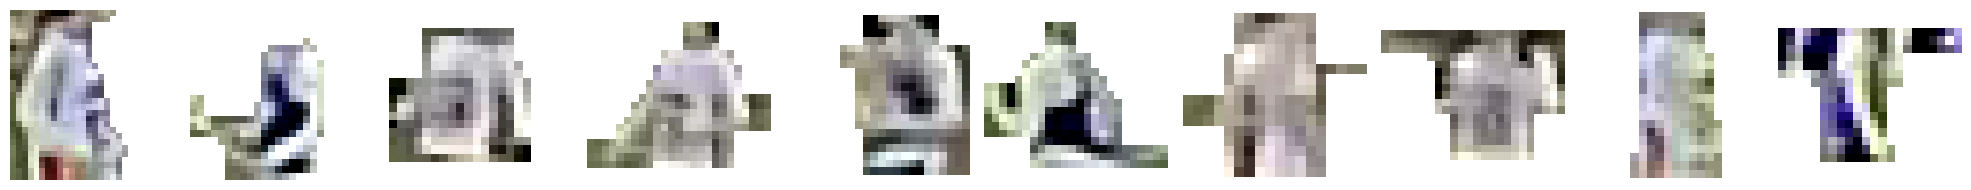

In [13]:
emb_provider = SiglipReID()
crops_pil = []
for i, masked_crop in enumerate(masked_crops):
    # Assume red background is [255, 0, 0] in RGB (or [0, 0, 255] in BGR)
    # If your masked_crop is RGB:
    masked_crop_rgb = masked_crop.copy()
    red_mask = np.all(masked_crop == [255, 0, 0], axis=-1)
    # If your masked_crop is BGR, use [0, 0, 255] instead
    masked_crop_rgb[red_mask] = [255, 255, 255]
    masked_crop_pil = Image.fromarray(masked_crop_rgb, mode="RGB")
    crops_pil.append(masked_crop_pil.copy())


fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, img in enumerate(crops_pil[:10]):
    axes[i].imshow(np.array(img))
    axes[i].axis('off')
plt.tight_layout()
plt.show()



In [14]:
embs = emb_provider.get_emb_from_crops(crops_pil, format="Pillow")

Generating embeddings: 100%|██████████| 53/53 [00:30<00:00,  1.73it/s]


Then we create 3D projections

In [20]:
REDUCER = umap.UMAP(n_components=3)
embs_3d = REDUCER.fit_transform(embs)

Then we create the clusters

Team 0


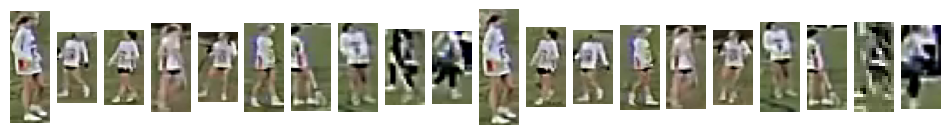

Team 1


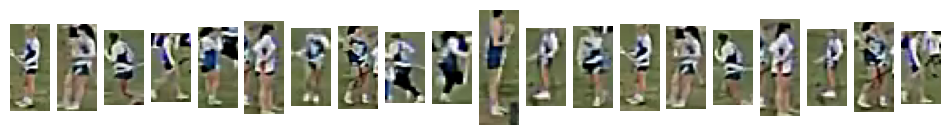

In [21]:
kmeans = KMeans(n_clusters=2, random_state=42)
embs_np = np.array(embs_3d)
team_identifier = kmeans.fit_predict(embs_np)

team_0 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 0]
team_1 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 1]

print("Team 0")
sv.plot_images_grid(team_0[:20], grid_size=(1, 20))

print("Team 1")
sv.plot_images_grid(team_1[:20], grid_size=(1, 20))

#### Using average color ####

Calculating average colors

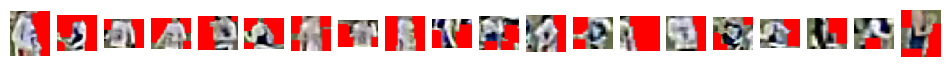

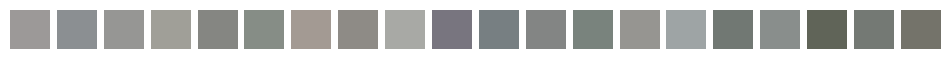

In [11]:
avg_colors = []
for crop in masked_crops:
    flat_crop = crop.reshape(-1, 3)
    red_mask = np.all(flat_crop == [255, 0, 0], axis=-1)
    flat_crop = flat_crop[~red_mask]  # Exclude red pixels
    crop_reshaped = flat_crop.reshape(1, -1, 3)
    crop_lab = cv2.cvtColor(crop_reshaped, cv2.COLOR_RGB2LAB)
    avg_color = np.mean(crop_lab, axis=(0, 1)).astype(np.uint8)
    avg_color = avg_color.reshape(1, 1, 3)  # Reshape for color conversion
    avg_color_bgr = cv2.cvtColor(avg_color, cv2.COLOR_LAB2BGR)
    avg_color_bgr = avg_color_bgr.reshape(3)  # Reshape to 1D array
    avg_colors.append(avg_color_bgr.copy())

color_patches = [np.full((5, 5, 3), color, dtype=np.uint8) for color in avg_colors]
masked_crops_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in masked_crops]
sv.plot_images_grid(masked_crops_bgr[:20], grid_size=(1, 20))
sv.plot_images_grid(color_patches[:20], grid_size=(1, 20))

Team 0


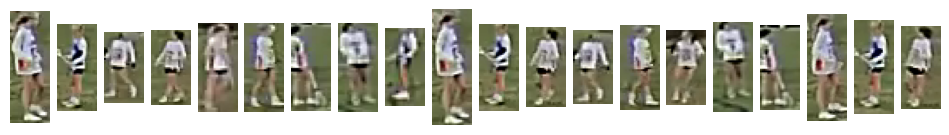

Team 1


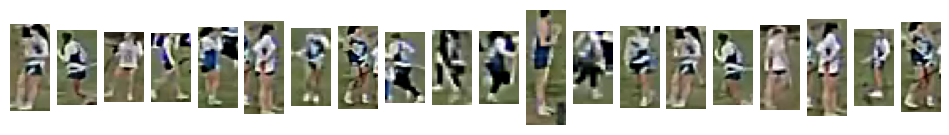

In [12]:
kmeans = KMeans(n_clusters=2, random_state=42)

embs_np = np.array(avg_colors)
 # Reshape to 2D array for KMeans
team_identifier = kmeans.fit_predict(embs_np)

team_0 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 0]
team_1 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 1]

print("Team 0")
sv.plot_images_grid(team_0[:20], grid_size=(1, 20))

print("Team 1")
sv.plot_images_grid(team_1[:20], grid_size=(1, 20))

### Experiment 3: Calculating the grass color and filtering it out.

#### Extract Grass Color ####

Gathering crops

Gathering crops for grass color: 100%|██████████| 5/5 [00:00<00:00, 17.94it/s]


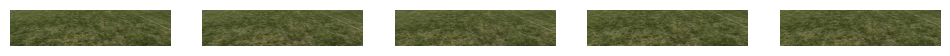

In [30]:
stride = frame_target // 5
crops_for_grass_color: List[np.ndarray] = []

frame_generator_for_grass_color = sv.get_video_frames_generator(stride=stride, **generator_params)

n_frames_for_grass_color = frame_target // stride if stride > 0 else frame_target
for frame in tqdm(frame_generator_for_grass_color, desc="Gathering crops for grass color", total=n_frames_for_grass_color):
    #removing the top 50% of the frame to avoid sky and the bottom 10% to avoid expectators
    crop = frame[int(frame.shape[0]*0.5):int(frame.shape[0]*0.9), :, :]
    crops_for_grass_color.append(crop)

sv.plot_images_grid(crops_for_grass_color, grid_size=(1, 5))


Calculating grass color mean and standard deviation using LAB.

Grass mean color: [ 94 118 150]
Grass std color: [33  1  2]
Grass mean color in RGB: [83 90 50]


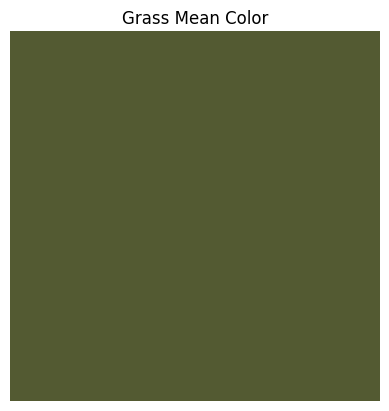

In [31]:
crops_for_grass_color_lab = [cv2.cvtColor(crop, cv2.COLOR_BGR2Lab) for crop in crops_for_grass_color]
crops_for_grass_color_lab = [crop.reshape(-1, 3) for crop in crops_for_grass_color_lab]
grass_flat_lab = np.concatenate(crops_for_grass_color_lab, axis=0)
grass_mean_color_lab = np.mean(grass_flat_lab, axis=0).astype(np.uint8)
grass_std_color_lab = np.std(grass_flat_lab, axis=0).astype(np.uint8)
print(f"Grass mean color: {grass_mean_color_lab}")
print(f"Grass std color: {grass_std_color_lab}")

grass_mean_color_rgb = cv2.cvtColor(grass_mean_color_lab.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
print(f"Grass mean color in RGB: {grass_mean_color_rgb}")

color_patch = np.full((5, 5, 3), grass_mean_color_rgb, dtype=np.uint8)
plt.imshow(color_patch)
plt.title("Grass Mean Color")
plt.axis('off')
plt.show()


Calculating grass color ranges based on number of standard deviations

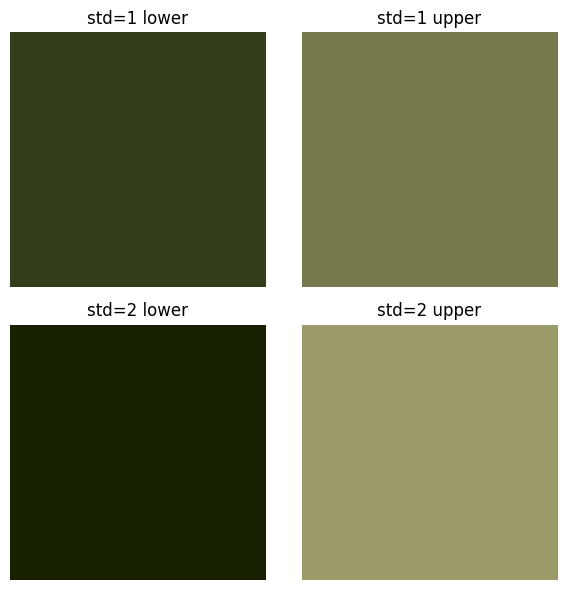

In [32]:

std_deviations = [1, 2]

lower_bounds = {}
upper_bounds = {}

for std in std_deviations:
    lower = grass_mean_color_lab - std * grass_std_color_lab
    upper = grass_mean_color_lab + std * grass_std_color_lab
    lower = np.clip(lower, 0, 255).astype(np.uint8)
    upper = np.clip(upper, 0, 255).astype(np.uint8)
    lower_bounds[std] = lower
    upper_bounds[std] = upper

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for row, std in enumerate(std_deviations):
    # Lower bound patch
    lower_patch = np.full((5, 5, 3), lower_bounds[std], dtype=np.uint8)
    lower_patch = cv2.cvtColor(lower_patch, cv2.COLOR_LAB2RGB)
    axes[row, 0].imshow(lower_patch)
    axes[row, 0].set_title(f"std={std} lower")
    axes[row, 0].axis('off')
    # Upper bound patch
    upper_patch = np.full((5, 5, 3), upper_bounds[std], dtype=np.uint8)
    upper_patch = cv2.cvtColor(upper_patch, cv2.COLOR_LAB2RGB)
    axes[row, 1].imshow(upper_patch)
    axes[row, 1].set_title(f"std={std} upper")
    axes[row, 1].axis('off')

plt.tight_layout()
plt.show()


#### Removing Grass Background ####

While 1 is not aggressive enough, 2 standard deviations is overly aggressive.

Original ROI Crops:


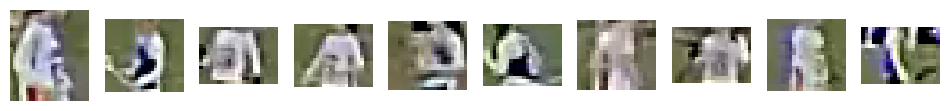

Masked ROI Crops (1 std):


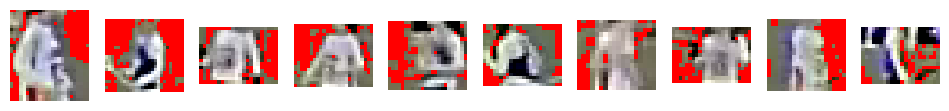

Masked ROI Crops (2 std):


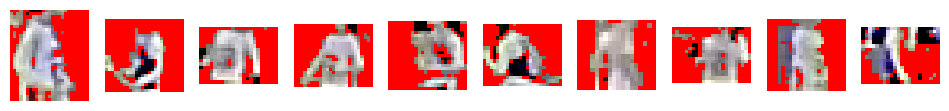

In [39]:
roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops_for_team_id_backup]

roi_crops_masked_1std = []
roi_crops_masked_2std = []

lower1 = cv2.cvtColor(lower_bounds[1].reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
upper1 = cv2.cvtColor(upper_bounds[1].reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
lower2 = cv2.cvtColor(lower_bounds[2].reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
upper2 = cv2.cvtColor(upper_bounds[2].reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)

lower1 = np.clip(lower1, 0, 255).astype(np.uint8)
upper1 = np.clip(upper1, 0, 255).astype(np.uint8)
lower2 = np.clip(lower2, 0, 255).astype(np.uint8)
upper2 = np.clip(upper2, 0, 255).astype(np.uint8)

for crop in roi_crops:
    # 1 std mask
    mask1 = cv2.inRange(crop, lower1, upper1)
    crop_masked1 = crop.copy()
    crop_masked1[mask1 > 0] = [255, 0, 0]
    roi_crops_masked_1std.append(crop_masked1)
    # 2 std mask
    mask2 = cv2.inRange(crop, lower2, upper2)
    crop_masked2 = crop.copy()
    crop_masked2[mask2 > 0] = [255, 0, 0]
    roi_crops_masked_2std.append(crop_masked2)

# Plot first 10 for each flavor
print("Original ROI Crops:")
sv.plot_images_grid([cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in roi_crops[:10]], grid_size=(1, 10))
print("Masked ROI Crops (1 std):")
sv.plot_images_grid([cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in roi_crops_masked_1std[:10]], grid_size=(1, 10))
print("Masked ROI Crops (2 std):")
sv.plot_images_grid([cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in roi_crops_masked_2std[:10]], grid_size=(1, 10))

Fixing the interval

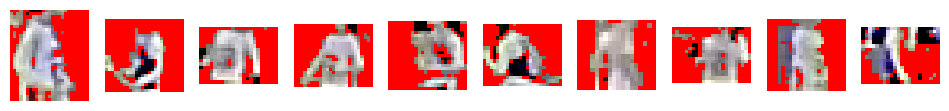

In [40]:
std = 2

lower = grass_mean_color_lab - std * grass_std_color_lab
upper = grass_mean_color_lab + std * grass_std_color_lab
lower = np.clip(lower, 0, 255).astype(np.uint8)
upper = np.clip(upper, 0, 255).astype(np.uint8)

roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops_for_team_id_backup]
roi_crops_masked = []

lower = cv2.cvtColor(lower.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
upper = cv2.cvtColor(upper.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)

lower = np.clip(lower, 0, 255).astype(np.uint8)
upper = np.clip(upper, 0, 255).astype(np.uint8)

for crop in roi_crops:
    mask = cv2.inRange(crop, lower, upper)
    crop_masked = crop.copy()
    crop_masked[mask > 0] = [255, 0, 0]
    roi_crops_masked.append(crop_masked)

sv.plot_images_grid([cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in roi_crops_masked[:10]], grid_size=(1, 10))
 


#### Cluster Using Average Colors ####

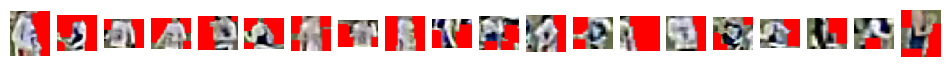

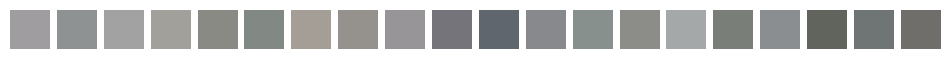

In [211]:
avg_colors = []
for crop in roi_crops_masked:
    flat_crop = crop.reshape(-1, 3)
    red_mask = np.all(flat_crop == [255, 0, 0], axis=-1)
    flat_crop = flat_crop[~red_mask]  # Exclude red pixels
    crop_reshaped = flat_crop.reshape(1, -1, 3)
    crop_lab = cv2.cvtColor(crop_reshaped, cv2.COLOR_RGB2LAB)
    avg_color = np.mean(crop_lab, axis=(0, 1)).astype(np.uint8)
    avg_color = avg_color.reshape(1, 1, 3)  # Reshape for color conversion
    avg_color_bgr = cv2.cvtColor(avg_color, cv2.COLOR_LAB2BGR)
    avg_color_bgr = avg_color_bgr.reshape(3)  # Reshape to 1D array
    avg_colors.append(avg_color_bgr.copy())

color_patches = [np.full((5, 5, 3), color, dtype=np.uint8) for color in avg_colors]
masked_crops_bgr = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop in masked_crops]
sv.plot_images_grid(masked_crops_bgr[:20], grid_size=(1, 20))
sv.plot_images_grid(color_patches[:20], grid_size=(1, 20))

Separate Teams

Team 0


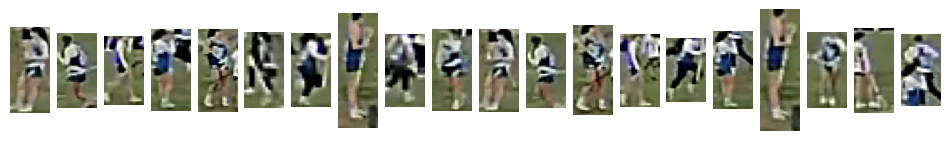

Team 1


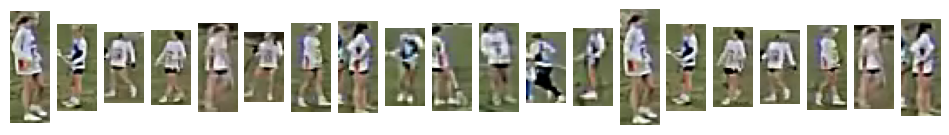

In [212]:
kmeans = KMeans(n_clusters=2, random_state=42)

embs_np = np.array(avg_colors)
 # Reshape to 2D array for KMeans
team_identifier = kmeans.fit_predict(embs_np)

team_0 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 0]
team_1 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 1]

print("Team 0")
sv.plot_images_grid(team_0[:20], grid_size=(1, 20))

print("Team 1")
sv.plot_images_grid(team_1[:20], grid_size=(1, 20))

#### Cluster Using SigLip ####

Creating embeddings

In [41]:
emb_provider = SiglipReID()
crops_pil = []
for i, masked_crop in enumerate(roi_crops_masked):
    # Assume red background is [255, 0, 0] in RGB (or [0, 0, 255] in BGR)
    # If your masked_crop is RGB:
    masked_crop_rgb = masked_crop.copy()
    red_mask = np.all(masked_crop == [255, 0, 0], axis=-1)
    # If your masked_crop is BGR, use [0, 0, 255] instead
    masked_crop_rgb[red_mask] = [255, 255, 255]
    masked_crop_pil = Image.fromarray(masked_crop_rgb, mode="RGB")
    crops_pil.append(masked_crop_pil.copy())

embs = emb_provider.get_emb_from_crops(crops_pil, format="Pillow")

REDUCER = umap.UMAP(n_components=3)
embs_3d = REDUCER.fit_transform(embs)


Generating embeddings: 100%|██████████| 53/53 [00:31<00:00,  1.67it/s]


Separating clusters

Team 0


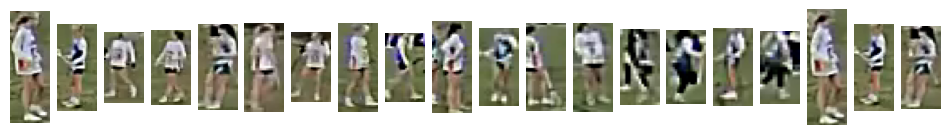

Team 1


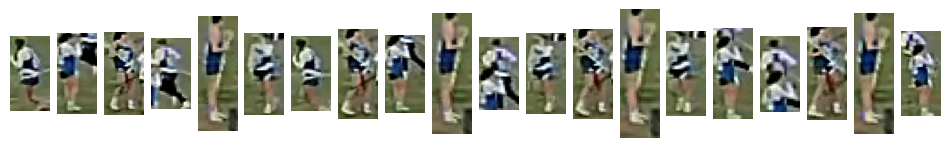

In [42]:
kmeans = KMeans(n_clusters=2, random_state=42)
embs_np = np.array(embs_3d)
team_identifier = kmeans.fit_predict(embs_np)

team_0 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 0]
team_1 = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops_for_team_id, team_identifier) if team == 1]

print("Team 0")
sv.plot_images_grid(team_0[:20], grid_size=(1, 20))

print("Team 1")
sv.plot_images_grid(team_1[:20], grid_size=(1, 20))

## Performance Study ##

In [11]:
videos = []
videos.append('/Users/fernandomousinho/Documents/Stella/Lacrosse/Spring2025 Raw Videos/ESD3.mp4')
videos.append('/Users/fernandomousinho/Documents/Stella/Lacrosse/Spring2025 Raw Videos/semis.mp4')
videos.append('/Users/fernandomousinho/Documents/Stella/Lacrosse/Spring2025 Raw Videos/keller.mp4')

# Performance comparison parameters
PERFORMANCE_MAX_FRAMES = 200
N_FRAMES_FOR_TEAM_ID = 50
PLAYER_CLASS_ID = 3

In [12]:
def extract_crops_from_video(video_path, max_frames=200, n_frames_for_team_id=50):
    """Extract player crops from video for team identification"""
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    generator_params = {
        "source_path": video_path,
        "end": min(max_frames, video_info.total_frames),
    }
    
    stride = max_frames // n_frames_for_team_id if max_frames >= n_frames_for_team_id else 1
    crops_for_team_id = []
    
    frame_generator = sv.get_video_frames_generator(stride=stride, **generator_params)
    n_frames = max_frames // stride if stride > 0 else max_frames
    
    for frame in tqdm(frame_generator, desc=f"Extracting crops from {video_path.split('/')[-1]}", total=n_frames):
        all_detections = model.generate_detections(frame)
        player_detections = all_detections[all_detections.class_id == PLAYER_CLASS_ID]
        for bbox in player_detections.xyxy:
            crop = sv.crop_image(frame, xyxy=bbox)
            if crop is not None:
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                crops_for_team_id.append(crop)
    
    return crops_for_team_id

def calculate_grass_color_bounds(video_path, max_frames=200, std_dev=2):
    """Calculate grass color bounds for masking"""
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    generator_params = {
        "source_path": video_path,
        "end": min(max_frames, video_info.total_frames),
    }
    
    stride = max_frames // 5
    crops_for_grass_color = []
    
    frame_generator = sv.get_video_frames_generator(stride=stride, **generator_params)
    n_frames = max_frames // stride if stride > 0 else max_frames
    
    for frame in tqdm(frame_generator, desc=f"Calculating grass color for {video_path.split('/')[-1]}", total=n_frames):
        # Remove top 50% and bottom 10% of frame
        crop = frame[int(frame.shape[0]*0.5):int(frame.shape[0]*0.9), :, :]
        crops_for_grass_color.append(crop)
    
    # Calculate grass color statistics in LAB space
    crops_lab = [cv2.cvtColor(crop, cv2.COLOR_BGR2Lab) for crop in crops_for_grass_color]
    crops_lab = [crop.reshape(-1, 3) for crop in crops_lab]
    grass_flat_lab = np.concatenate(crops_lab, axis=0)
    grass_mean_color_lab = np.mean(grass_flat_lab, axis=0).astype(np.uint8)
    grass_std_color_lab = np.std(grass_flat_lab, axis=0).astype(np.uint8)
    
    # Calculate bounds
    n_of_std_dev = 2
    lower = grass_mean_color_lab - n_of_std_dev * grass_std_color_lab
    upper = grass_mean_color_lab + n_of_std_dev * grass_std_color_lab
    lower = np.clip(lower, 0, 255).astype(np.uint8)
    upper = np.clip(upper, 0, 255).astype(np.uint8)
    
    # Convert to RGB for masking
    lower_rgb = cv2.cvtColor(lower.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
    upper_rgb = cv2.cvtColor(upper.reshape(1, 1, 3), cv2.COLOR_LAB2RGB).reshape(3)
    
    return np.clip(lower_rgb, 0, 255).astype(np.uint8), np.clip(upper_rgb, 0, 255).astype(np.uint8)

def method1_morph_siglip(crops):
    """Method 1: Morphological operations + SigLip clustering"""
    # ROI extraction
    roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
    
    # Morphological masking
    shapes = []
    flat_crop_array = []
    for crop in roi_crops:
        shapes.append(crop.shape)
        flat_crop = crop.reshape(-1, 3).astype(np.float32) / 255.0
        flat_crop_array.append(flat_crop)
    
    flat_crop_norm = np.concatenate(flat_crop_array, axis=0)
    kmeans_background = KMeans(n_clusters=2, random_state=42)
    player_or_grass_mask = kmeans_background.fit_predict(flat_crop_norm)
    
    masked_crops = []
    start = 0
    kernel_open = np.ones((7, 7), np.uint8)
    
    for i, shape in enumerate(shapes):
        stop = start + shape[0] * shape[1]
        flat_mask = player_or_grass_mask[start:stop]
        mask = np.reshape(flat_mask, shape[:2])
        mask_edges = set([mask[0, 0], mask[0, -1], mask[-1, 0], mask[-1, -1]])
        grass_cluster = max(mask_edges, key=list(mask_edges).count)
        player_img_cluster = 1 - grass_cluster
        mask = (mask == player_img_cluster).astype(np.uint8)

        mask_rgb = cv2.cvtColor(mask.astype(np.uint8) * 255, cv2.COLOR_GRAY2RGB)
        mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_OPEN, kernel_open)
        mask = cv2.bitwise_not(mask_rgb[:, :, 0])
        
        masked_crop = roi_crops[i].copy()
        masked_crop = cv2.bitwise_and(masked_crop, masked_crop, mask=mask)
        masked_crop[mask == 0] = [255, 255, 255]  # White background
        masked_crops.append(masked_crop)
        start = stop
    
    # SigLip embeddings
    crops_pil = [Image.fromarray(crop, mode="RGB") for crop in masked_crops]
    embs = emb_provider.get_emb_from_crops(crops_pil, format="Pillow")
    
    # 3D UMAP + clustering
    reducer = umap.UMAP(n_components=3, random_state=42)
    embs_3d = reducer.fit_transform(embs)
    kmeans = KMeans(n_clusters=2, random_state=42)
    team_labels = kmeans.fit_predict(embs_3d)
    
    return team_labels

def method2_morph_avgcolor(crops):
    """Method 2: Morphological operations + Average color clustering"""
    # ROI extraction
    roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
    
    # Morphological masking (same as method 1)
    shapes = []
    flat_crop_array = []
    for crop in roi_crops:
        shapes.append(crop.shape)
        flat_crop = crop.reshape(-1, 3).astype(np.float32) / 255.0
        flat_crop_array.append(flat_crop)
    
    flat_crop_norm = np.concatenate(flat_crop_array, axis=0)
    kmeans_background = KMeans(n_clusters=2, random_state=42)
    player_or_grass_mask = kmeans_background.fit_predict(flat_crop_norm)
    
    masked_crops = []
    start = 0
    kernel_open = np.ones((7, 7), np.uint8)
    
    for i, shape in enumerate(shapes):
        stop = start + shape[0] * shape[1]
        flat_mask = player_or_grass_mask[start:stop]
        mask = np.reshape(flat_mask, shape[:2])

        mask_edges = set([mask[0, 0], mask[0, -1], mask[-1, 0], mask[-1, -1]])
        grass_cluster = max(mask_edges, key=list(mask_edges).count)
        player_img_cluster = 1 - grass_cluster
        mask = (mask == player_img_cluster).astype(np.uint8)
        mask_rgb = cv2.cvtColor(mask.astype(np.uint8) * 255, cv2.COLOR_GRAY2RGB)

        mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_OPEN, kernel_open)
        mask = cv2.bitwise_not(mask_rgb[:, :, 0])
        
        masked_crop = roi_crops[i].copy()
        masked_crop = cv2.bitwise_and(masked_crop, masked_crop, mask=mask)
        masked_crop[mask == 0] = [255, 0, 0]  # Red background for exclusion
        masked_crops.append(masked_crop)
        start = stop
    
    # Average color calculation
    avg_colors = []
    for crop in masked_crops:
        flat_crop = crop.reshape(-1, 3)
        red_mask = np.all(flat_crop == [255, 0, 0], axis=-1)
        flat_crop = flat_crop[~red_mask]
        if len(flat_crop) > 0:
            crop_reshaped = flat_crop.reshape(1, -1, 3)
            crop_lab = cv2.cvtColor(crop_reshaped, cv2.COLOR_RGB2LAB)
            avg_color = np.mean(crop_lab, axis=(0, 1)).astype(np.uint8)
            avg_colors.append(avg_color)
        else:
            avg_colors.append(np.array([128, 128, 128]))  # Default gray
    
    # Clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    team_labels = kmeans.fit_predict(avg_colors)
    
    return team_labels

def method3_grass_siglip(crops, grass_lower, grass_upper):
    """Method 3: Grass color masking + SigLip clustering"""
    # ROI extraction
    roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
    
    # Grass color masking
    roi_crops_masked = []
    for crop in roi_crops:
        mask = cv2.inRange(crop, grass_lower, grass_upper)
        crop_masked = crop.copy()
        crop_masked[mask > 0] = [255, 255, 255]  # White background
        roi_crops_masked.append(crop_masked)
    
    # SigLip embeddings
    crops_pil = [Image.fromarray(crop, mode="RGB") for crop in roi_crops_masked]
    embs = emb_provider.get_emb_from_crops(crops_pil, format="Pillow")
    
    # 3D UMAP + clustering
    reducer = umap.UMAP(n_components=3, random_state=42)
    embs_3d = reducer.fit_transform(embs)
    kmeans = KMeans(n_clusters=2, random_state=42)
    team_labels = kmeans.fit_predict(embs_3d)
    
    return team_labels

def method4_grass_avgcolor(crops, grass_lower, grass_upper):
    """Method 4: Grass color masking + Average color clustering"""
    # ROI extraction
    roi_crops = [crop[int(crop.shape[0]*0.1):int(crop.shape[0]*0.5), :, :] for crop in crops]
    
    # Grass color masking
    roi_crops_masked = []
    for crop in roi_crops:
        mask = cv2.inRange(crop, grass_lower, grass_upper)
        crop_masked = crop.copy()
        crop_masked[mask > 0] = [255, 0, 0]  # Red background for exclusion
        roi_crops_masked.append(crop_masked)
    
    # Average color calculation
    avg_colors = []
    for crop in roi_crops_masked:
        flat_crop = crop.reshape(-1, 3)
        red_mask = np.all(flat_crop == [255, 0, 0], axis=-1)
        flat_crop = flat_crop[~red_mask]
        if len(flat_crop) > 0:
            crop_reshaped = flat_crop.reshape(1, -1, 3)
            crop_lab = cv2.cvtColor(crop_reshaped, cv2.COLOR_RGB2LAB)
            avg_color = np.mean(crop_lab, axis=(0, 1)).astype(np.uint8)
            avg_colors.append(avg_color)
        else:
            avg_colors.append(np.array([128, 128, 128]))  # Default gray
    
    # Clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    team_labels = kmeans.fit_predict(avg_colors)
    
    return team_labels

In [13]:
# Performance comparison across all videos and methods
results = {}

for video_idx, video_path in enumerate(videos):
    print(f"\n{'='*60}")
    print(f"Processing Video {video_idx + 1}: {video_path.split('/')[-1]}")
    print(f"{'='*60}")
    
    # Extract crops for this video
    crops = extract_crops_from_video(video_path, PERFORMANCE_MAX_FRAMES, N_FRAMES_FOR_TEAM_ID)
    print(f"Extracted {len(crops)} player crops")
    
    # Calculate grass color bounds for this video
    grass_lower, grass_upper = calculate_grass_color_bounds(video_path, PERFORMANCE_MAX_FRAMES)
    print(f"Grass color bounds: Lower={grass_lower}, Upper={grass_upper}")
    
    # Apply all 4 methods
    print("\nApplying team identification methods...")
    
    try:
        team_labels_1 = method1_morph_siglip(crops)
        print("✓ Method 1: Morphological + SigLip completed")
    except Exception as e:
        print(f"✗ Method 1 failed: {e}")
        team_labels_1 = np.zeros(len(crops))
    
    try:
        team_labels_2 = method2_morph_avgcolor(crops)
        print("✓ Method 2: Morphological + Average Color completed")
    except Exception as e:
        print(f"✗ Method 2 failed: {e}")
        team_labels_2 = np.zeros(len(crops))
    
    try:
        team_labels_3 = method3_grass_siglip(crops, grass_lower, grass_upper)
        print("✓ Method 3: Grass Color + SigLip completed")
    except Exception as e:
        print(f"✗ Method 3 failed: {e}")
        team_labels_3 = np.zeros(len(crops))
    
    try:
        team_labels_4 = method4_grass_avgcolor(crops, grass_lower, grass_upper)
        print("✓ Method 4: Grass Color + Average Color completed")
    except Exception as e:
        print(f"✗ Method 4 failed: {e}")
        team_labels_4 = np.zeros(len(crops))
    
    # Store results
    results[video_path] = {
        'crops': crops,
        'method1': team_labels_1,
        'method2': team_labels_2,
        'method3': team_labels_3,
        'method4': team_labels_4
    }

print(f"\n{'='*60}")
print("Performance comparison completed!")
print(f"{'='*60}")


Processing Video 1: ESD3.mp4


Extracting crops from ESD3.mp4: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


Extracted 42 player crops


Calculating grass color for ESD3.mp4: 100%|██████████| 5/5 [00:00<00:00, 61.91it/s]


Grass color bounds: Lower=[ 0 40 38], Upper=[171 145 106]

Applying team identification methods...


Generating embeddings: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


✓ Method 1: Morphological + SigLip completed
✓ Method 2: Morphological + Average Color completed


Generating embeddings: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


✓ Method 3: Grass Color + SigLip completed
✓ Method 4: Grass Color + Average Color completed

Processing Video 2: semis.mp4


Extracting crops from semis.mp4: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


Extracted 596 player crops


Calculating grass color for semis.mp4: 100%|██████████| 5/5 [00:00<00:00, 59.42it/s]


Grass color bounds: Lower=[25 97 61], Upper=[146 153  70]

Applying team identification methods...


Generating embeddings: 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]


✓ Method 1: Morphological + SigLip completed
✓ Method 2: Morphological + Average Color completed


Generating embeddings: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


✓ Method 3: Grass Color + SigLip completed
✓ Method 4: Grass Color + Average Color completed

Processing Video 3: keller.mp4


Extracting crops from keller.mp4: 100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


Extracted 852 player crops


Calculating grass color for keller.mp4: 100%|██████████| 5/5 [00:00<00:00, 31.77it/s]


Grass color bounds: Lower=[ 0 43 53], Upper=[163 159 150]

Applying team identification methods...


Generating embeddings: 100%|██████████| 27/27 [00:16<00:00,  1.68it/s]


✓ Method 1: Morphological + SigLip completed
✓ Method 2: Morphological + Average Color completed


Generating embeddings: 100%|██████████| 27/27 [00:15<00:00,  1.70it/s]


✓ Method 3: Grass Color + SigLip completed
✓ Method 4: Grass Color + Average Color completed

Performance comparison completed!



RESULTS FOR VIDEO 1: ESD3.mp4


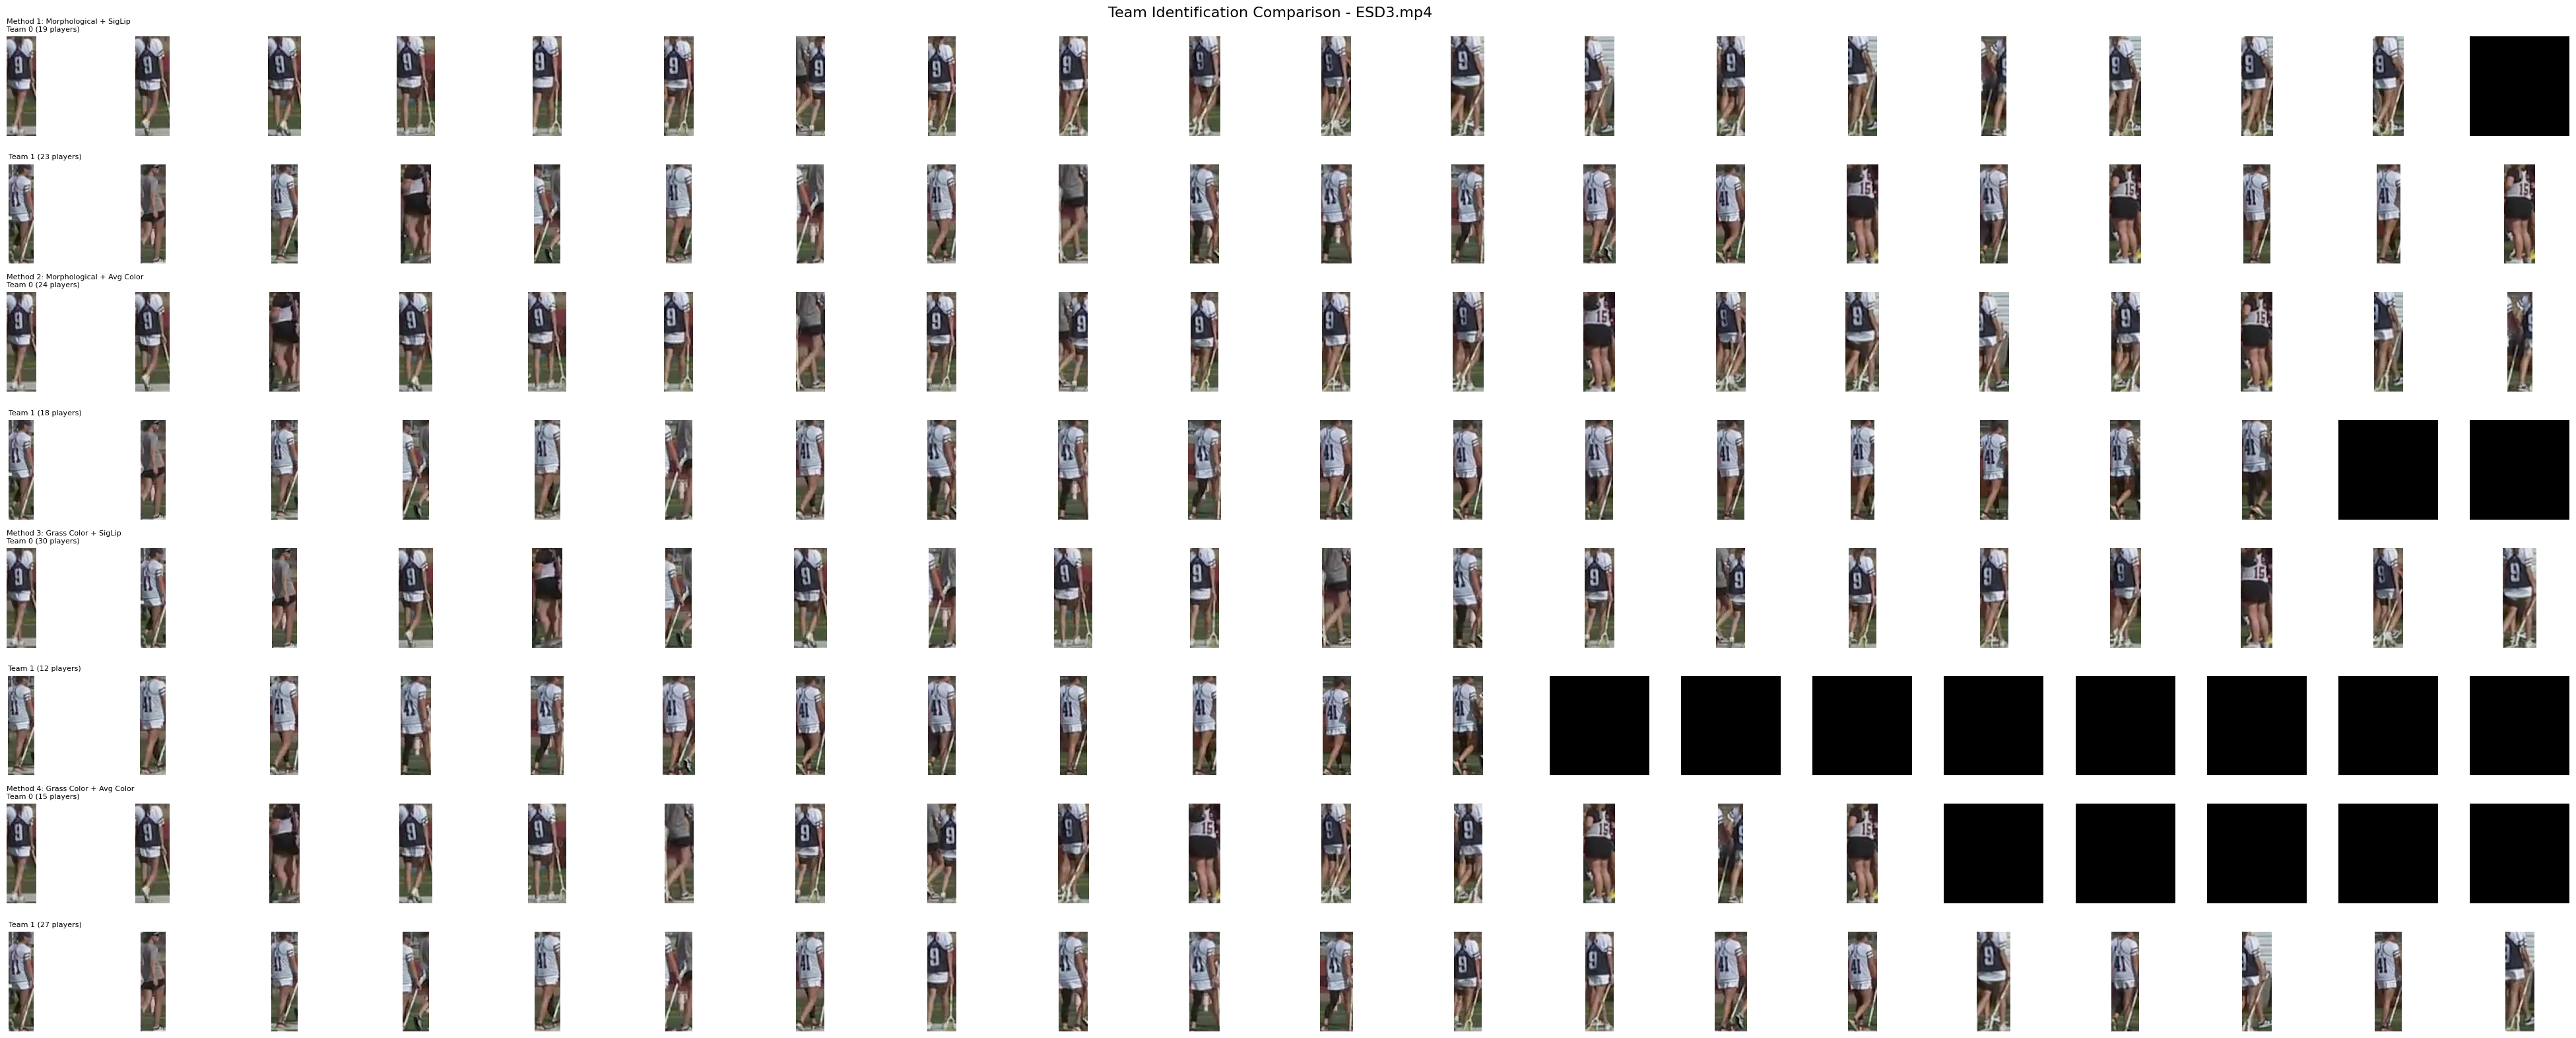


Summary Statistics for ESD3.mp4:
--------------------------------------------------
Method 1: Morphological + SigLip:
  Team 0: 19 players
  Team 1: 23 players
  Total: 42 players
  Balance: 0.83

Method 2: Morphological + Avg Color:
  Team 0: 24 players
  Team 1: 18 players
  Total: 42 players
  Balance: 0.75

Method 3: Grass Color + SigLip:
  Team 0: 30 players
  Team 1: 12 players
  Total: 42 players
  Balance: 0.40

Method 4: Grass Color + Avg Color:
  Team 0: 15 players
  Team 1: 27 players
  Total: 42 players
  Balance: 0.56


RESULTS FOR VIDEO 2: semis.mp4


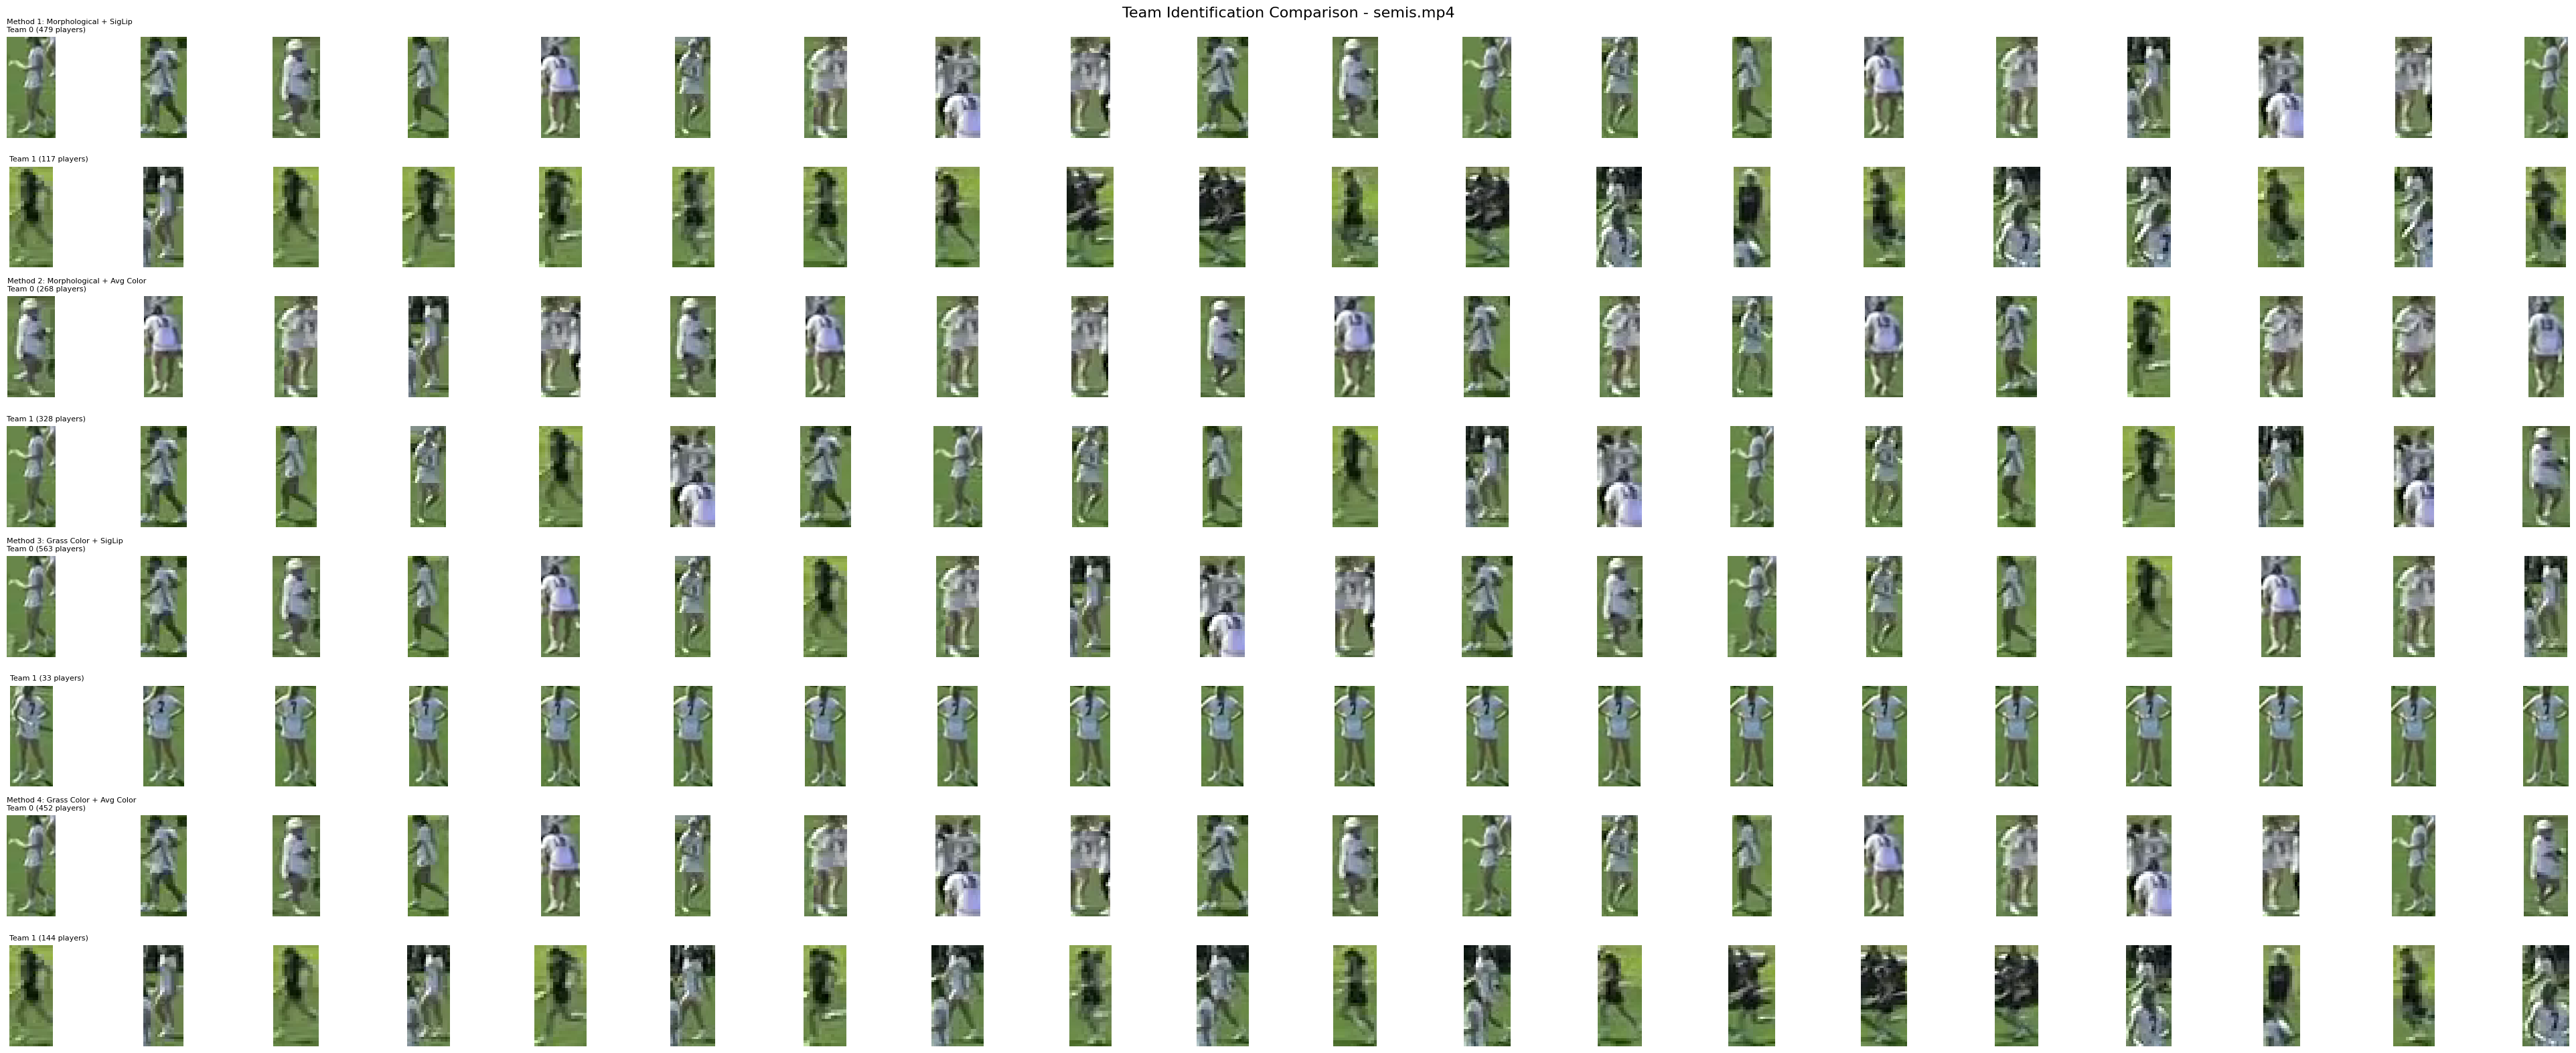


Summary Statistics for semis.mp4:
--------------------------------------------------
Method 1: Morphological + SigLip:
  Team 0: 479 players
  Team 1: 117 players
  Total: 596 players
  Balance: 0.24

Method 2: Morphological + Avg Color:
  Team 0: 268 players
  Team 1: 328 players
  Total: 596 players
  Balance: 0.82

Method 3: Grass Color + SigLip:
  Team 0: 563 players
  Team 1: 33 players
  Total: 596 players
  Balance: 0.06

Method 4: Grass Color + Avg Color:
  Team 0: 452 players
  Team 1: 144 players
  Total: 596 players
  Balance: 0.32


RESULTS FOR VIDEO 3: keller.mp4


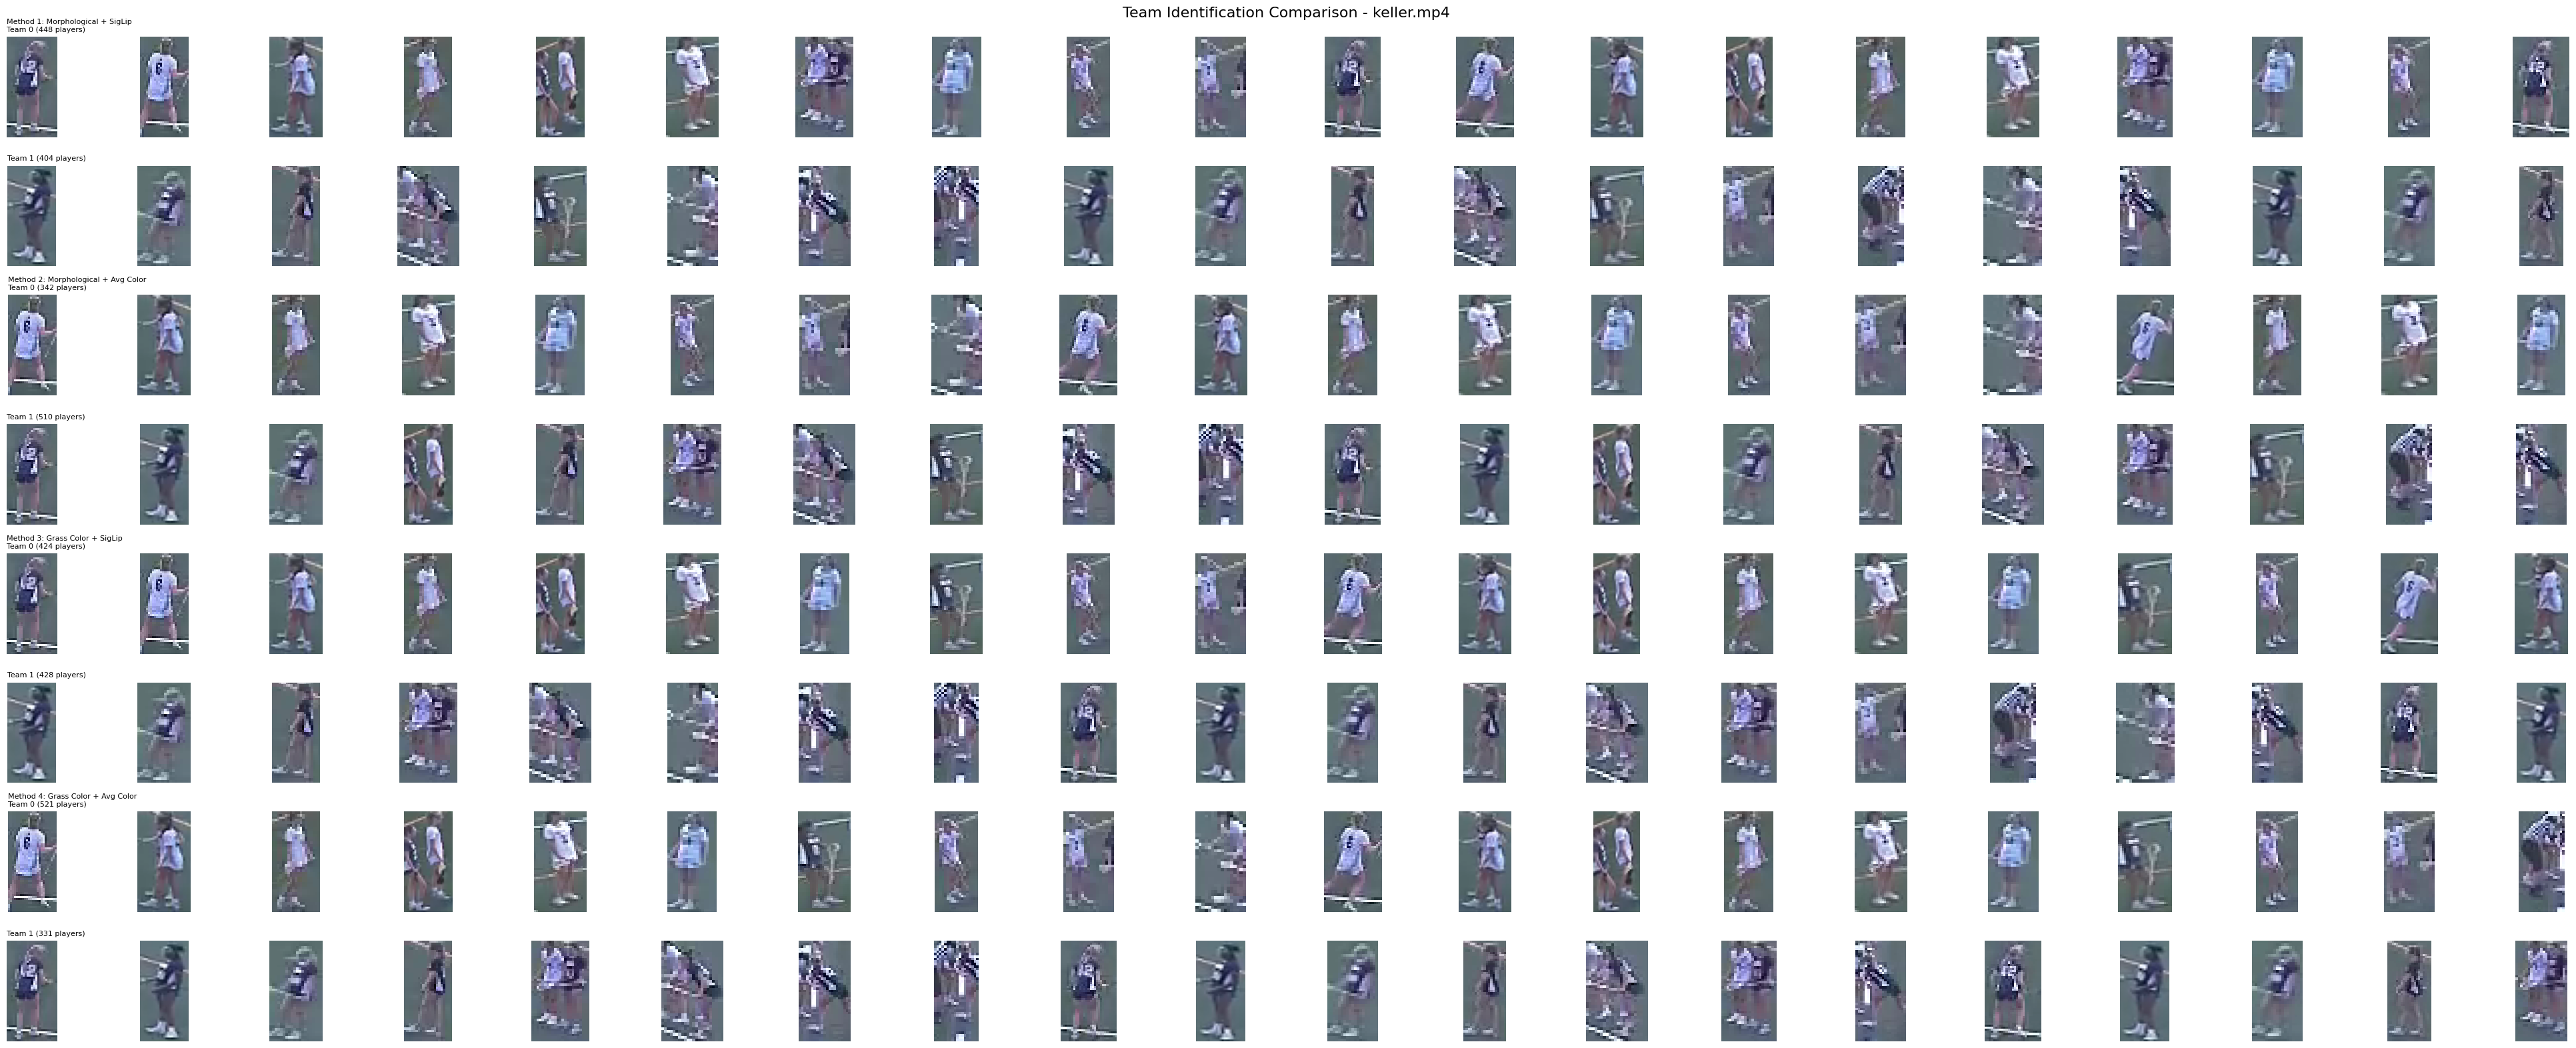


Summary Statistics for keller.mp4:
--------------------------------------------------
Method 1: Morphological + SigLip:
  Team 0: 448 players
  Team 1: 404 players
  Total: 852 players
  Balance: 0.90

Method 2: Morphological + Avg Color:
  Team 0: 342 players
  Team 1: 510 players
  Total: 852 players
  Balance: 0.67

Method 3: Grass Color + SigLip:
  Team 0: 424 players
  Team 1: 428 players
  Total: 852 players
  Balance: 0.99

Method 4: Grass Color + Avg Color:
  Team 0: 521 players
  Team 1: 331 players
  Total: 852 players
  Balance: 0.64


PERFORMANCE COMPARISON COMPLETE


In [14]:
# Visualize results in a comparative grid
method_names = [
    "Method 1: Morphological + SigLip",
    "Method 2: Morphological + Avg Color", 
    "Method 3: Grass Color + SigLip",
    "Method 4: Grass Color + Avg Color"
]

for video_idx, (video_path, video_results) in enumerate(results.items()):
    print(f"\n{'='*80}")
    print(f"RESULTS FOR VIDEO {video_idx + 1}: {video_path.split('/')[-1]}")
    print(f"{'='*80}")
    
    crops = video_results['crops']
    
    # Create a large figure for all methods
    fig, axes = plt.subplots(8, 20, figsize=(40, 16))
    fig.suptitle(f"Team Identification Comparison - {video_path.split('/')[-1]}", fontsize=16)
    
    # For each method, show teams in rows
    for method_idx, method_key in enumerate(['method1', 'method2', 'method3', 'method4']):
        team_labels = video_results[method_key]
        
        # Get crops for each team
        team_0_crops = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops, team_labels) if team == 0]
        team_1_crops = [cv2.cvtColor(crop, cv2.COLOR_RGB2BGR) for crop, team in zip(crops, team_labels) if team == 1]
        
        # Display Team 0 (row = method_idx * 2)
        row_0 = method_idx * 2
        for i in range(20):
            if i < len(team_0_crops):
                axes[row_0, i].imshow(cv2.cvtColor(team_0_crops[i], cv2.COLOR_BGR2RGB))
            else:
                axes[row_0, i].imshow(np.zeros((50, 50, 3), dtype=np.uint8))  # Empty placeholder
            axes[row_0, i].axis('off')
            if i == 0:
                axes[row_0, i].set_title(f"{method_names[method_idx]}\nTeam 0 ({len(team_0_crops)} players)", 
                                       fontsize=8, loc='left')
        
        # Display Team 1 (row = method_idx * 2 + 1)
        row_1 = method_idx * 2 + 1
        for i in range(20):
            if i < len(team_1_crops):
                axes[row_1, i].imshow(cv2.cvtColor(team_1_crops[i], cv2.COLOR_BGR2RGB))
            else:
                axes[row_1, i].imshow(np.zeros((50, 50, 3), dtype=np.uint8))  # Empty placeholder
            axes[row_1, i].axis('off')
            if i == 0:
                axes[row_1, i].set_title(f"Team 1 ({len(team_1_crops)} players)", 
                                       fontsize=8, loc='left')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics for {video_path.split('/')[-1]}:")
    print("-" * 50)
    
    for method_idx, method_key in enumerate(['method1', 'method2', 'method3', 'method4']):
        team_labels = video_results[method_key]
        team_0_count = np.sum(team_labels == 0)
        team_1_count = np.sum(team_labels == 1)
        
        print(f"{method_names[method_idx]}:")
        print(f"  Team 0: {team_0_count} players")
        print(f"  Team 1: {team_1_count} players")
        print(f"  Total: {len(team_labels)} players")
        print(f"  Balance: {min(team_0_count, team_1_count) / max(team_0_count, team_1_count):.2f}")
        print()

print(f"\n{'='*80}")
print("PERFORMANCE COMPARISON COMPLETE")
print(f"{'='*80}")

### Performance Analysis ###

In [21]:
import json
import os
from IPython.display import display, clear_output
import ipywidgets as widgets

# Initialize ground truth storage
ground_truth = {}

# Start with the first video
current_video_idx = 2
current_video_path = videos[current_video_idx]
current_crops = results[current_video_path]['crops']

print(f"Starting ground truth classification for Video {current_video_idx + 1}: {current_video_path.split('/')[-1]}")
print(f"Total crops to classify: {len(current_crops)}")
print("\nFor each crop, please respond with:")
print("- 'l' or 'light' for light team")
print("- 'd' or 'dark' for dark team") 
print("- 'n' or 'none' for non-player crops")
print("- 'q' to quit and save progress")
print("=" * 60)

# Initialize ground truth for this video
ground_truth[current_video_path] = []

# Start with the first crop
current_crop_idx = 0

def show_current_crop():
    global current_crop_idx, current_video_idx, current_video_path, current_crops
    
    if current_crop_idx < len(current_crops):
        crop = current_crops[current_crop_idx]
        crop_bgr = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
        
        plt.figure(figsize=(4, 6))
        plt.imshow(cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB))
        plt.title(f"Video {current_video_idx + 1}: {current_video_path.split('/')[-1]}\nCrop {current_crop_idx + 1}/{len(current_crops)}")
        plt.axis('off')
        plt.show()
        
        print(f"Crop {current_crop_idx + 1}/{len(current_crops)}")
        
        # Get user input
        while True:
            user_input = input("Classify as (l)ight, (d)ark, (n)one, or (q)uit: ").strip().lower()
            
            if user_input in ['l', 'light']:
                ground_truth[current_video_path].append('light')
                print("✓ Classified as light team")
                break
            elif user_input in ['d', 'dark']:
                ground_truth[current_video_path].append('dark')
                print("✓ Classified as dark team")
                break
            elif user_input in ['n', 'none']:
                ground_truth[current_video_path].append('none')
                print("✓ Classified as non-player")
                break
            elif user_input in ['q', 'quit']:
                print("Saving progress and quitting...")
                save_ground_truth()
                return False
            else:
                print("Invalid input. Please enter 'l', 'd', 'n', or 'q'")
        
        current_crop_idx += 1
        clear_output(wait=True)
        return True
    else:
        print("All crops for this video have been classified!")
        save_ground_truth()
        return False

def save_ground_truth():
    """Save ground truth to JSON file"""
    filename = f"ground_truth_video_{current_video_idx + 1}.json"
    with open(filename, 'w') as f:
        json.dump(ground_truth, f, indent=2)
    print(f"Ground truth saved to {filename}")

def continue_classification():
    """Continue classification process"""
    while show_current_crop():
        pass

# Show the first crop and start the process
print("Starting classification...")
continue_classification()

All crops for this video have been classified!
Ground truth saved to ground_truth_video_3.json


In [23]:
from sklearn.metrics import f1_score
import json

# Load ground truth for the current video
ground_truth_file = f"ground_truth_video_{video_idx + 1}.json"
with open(ground_truth_file, "r") as f:
    gt_data = json.load(f)

# Get ground truth labels for this video (including 'none')
gt_labels = []
for label in gt_data[video_path]:
    if label == 'light':
        gt_labels.append(0)
    elif label == 'dark':
        gt_labels.append(1)
    else:
        gt_labels.append(2)  # 'none'

method_keys = ['method1', 'method2', 'method3', 'method4']
f1_scores = {}

for method in method_keys:
    pred = video_results[method]
    # Determine which cluster is lighter
    crops = video_results['crops']
    cluster0_mean = []
    cluster1_mean = []
    for i, p in enumerate(pred):
        crop = crops[i]
        crop_flat = crop.reshape(-1, 3)
        mean_brightness = crop_flat.mean()
        if p == 0:
            cluster0_mean.append(mean_brightness)
        else:
            cluster1_mean.append(mean_brightness)
    mean0 = np.mean(cluster0_mean) if cluster0_mean else 0
    mean1 = np.mean(cluster1_mean) if cluster1_mean else 0
    # Map: 0=light, 1=dark
    if mean0 > mean1:
        mapped_pred = [0 if p == 0 else 1 for p in pred]
    else:
        mapped_pred = [1 if p == 0 else 0 for p in pred]
    # Add 'none' for non-player crops
    mapped_pred_full = []
    for i, gt in enumerate(gt_labels):
        if gt == 2:
            mapped_pred_full.append(2)
        else:
            mapped_pred_full.append(mapped_pred[i])
    # Compute F1 (macro, including 'none')
    f1 = f1_score(gt_labels, mapped_pred_full, average='macro', labels=[0, 1, 2])
    f1_scores[method] = f1

print("F1 Scores (macro, including 'none') for each method:")
for method in method_keys:
    print(f"{method}: {f1_scores[method]:.3f}")

F1 Scores (macro, including 'none') for each method:
method1: 0.919
method2: 0.903
method3: 0.900
method4: 0.908


### Conclusion ###

The empirical data above suggests the following algorithm as reasonable for our purposes:

- Use Kmeans for each crop to determine the two prevalent colors. One of these colors will probably be the field color (grass or otherwise).
- Use morpholigical treatment to prevent colors in the player jersey from being masked-out
- Calculate the average color of the masked player
- Use Kmeans to separate the two teams

Admmitedlly, this conclusion is purely based on observation. A data-driven analysis with ore video and proper F1 score calculation might be prudent in the future.